---
layout: post
category: blog
title: Compare Countries and Cities with OpenStreetMap and t-SNE
tags: [OpenStreetMap, Overpass API, GIS, Python]
image: /assets/NOS_135192661848.jpg
imageurl: http://nos.twnsnd.co/image/135192661848
imagesource: New Old Stock
---

There are many ways to compare countries and cities and many measurements to choose from. We can see how they perform economically, or how their demographics differ, but what if we take a look at data available in [OpenStreetMap](https://www.openstreetmap.org/)? In this article we explore just that with the help of a procedure called t-SNE.

In the previous article [How to Predict Economic Indicators with OpenStreetMap]({{ site.baseurl }}{% link _posts/2018-05-15-osm-predict-economic-indicators.md
 %}) we explored how to use the amenities found in [OpenStreetmap](https://www.openstreetmap.org/) (OSM) for different countries to predict economic indicators. In this article we will continue and take a closer look at how to use the amenity distributions to compare and cluster countries and cities. All the code used for this and the previous article can be found in this [repository](https://github.com/njanakiev/osm-predict-economic-measurements).

# Understanding the Data

The data we are looking at, consists of the number of various amenities for countries in the european union (EU) and member states of the european free trade association (EFTA). 

OSM is structured in nodes, ways and relations, which describe the geometry. These [elements](https://wiki.openstreetmap.org/wiki/Elements) of OSM can have tags giving us additional information about the geometry, which are stored as key-value pairs. We are interested in tags with the [amenity](https://wiki.openstreetmap.org/wiki/Key:amenity) key which tags different community facilities such as _university_, _school_, _restaurant_, _atm_ and various others. We have selected the top 50 amenities listed in [taginfo](https://taginfo.openstreetmap.org/keys/amenity#values), and we have then collected the counts for these amenities within the country border for our selected countries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline


# Get population
df_population = pd.read_csv('data/economic_measurements.csv', index_col='country')
df_population = df_population[['Population']]

# Get amenity counts
df_amenity = pd.read_csv('data/country_amenity_counts.csv')
df_amenity.set_index('country', inplace=True)
df_amenity.drop(columns='country_code', inplace=True)

# Replace 0 values with 0.1 (important for logarithmic representation)
df_amenity = df_amenity.applymap(lambda x: 0.1 if x == 0 else float(x))

# Normalize amenities of each country by their population
df_amenity_normalized = df_amenity.apply(
    lambda row: row / df_population['Population'].loc[row.name], axis=1)

df_amenity.head()

,parking,place_of_worship,school,bench,restaurant,fuel,cafe,fast_food,bank,waste_basket,...,waste_disposal,marketplace,bus_station,university,college,parking_entrance,swimming_pool,theatre,taxi,veterinary
country,,,,,,,,,,,,,,,,,,,,,
Belgium,33209.0,6644.0,5936.0,15257.0,7549.0,2414.0,2496.0,3441.0,2529.0,9439.0,...,80.0,124.0,79.0,520.0,248.0,430.0,408.0,333.0,79.0,370.0
Bulgaria,4978.0,1964.0,1686.0,372.0,2828.0,1437.0,1353.0,710.0,925.0,72.0,...,68.0,182.0,222.0,162.0,51.0,56.0,84.0,121.0,193.0,81.0
Czech Republic,29815.0,8010.0,3768.0,14759.0,10271.0,2580.0,2057.0,2069.0,1291.0,2424.0,...,335.0,98.0,444.0,280.0,487.0,352.0,118.0,374.0,65.0,290.0
Denmark,32094.0,2620.0,2249.0,4168.0,2840.0,1810.0,3067.0,6780.0,682.0,1122.0,...,100.0,49.0,219.0,181.0,126.0,263.0,18.0,178.0,131.0,65.0
Germany,403687.0,62159.0,38465.0,333044.0,94386.0,17898.0,28377.0,31867.0,25452.0,61599.0,...,2054.0,1494.0,1842.0,2624.0,1188.0,8359.0,120.0,2596.0,4054.0,3417.0


This is an excerpt of our data set. In the next parallel coordinates plot we can see all of the amenties for all of the countries.

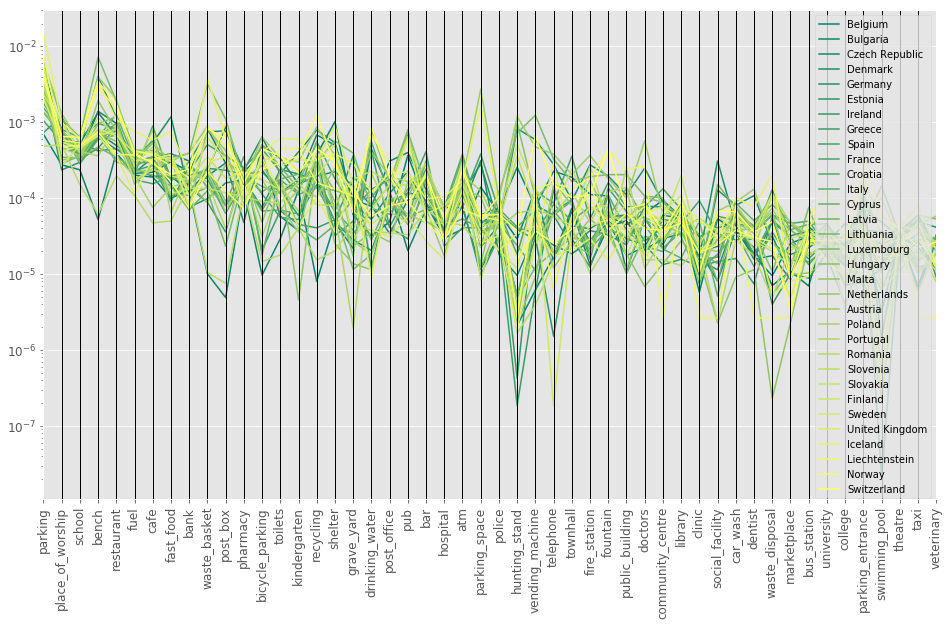

In [3]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(16, 9))
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
ax = parallel_coordinates(df_amenity_normalized.reset_index(), 'country', colormap='summer')
ax.set_yscale('log')
plt.legend(fontsize=10);

We can't quite make ourself an image from this, but it gives us a rough overview how the data is distributed. Let's now have a look how we can reduce the dimensionality to explore the relationship between the countries.

## Principal Component Analysis

One important and extremely valuable procedure for dimensionality reduction is the [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). The aim is to reduce dimensionality while retaining as much of the variance as possible. This is done by finding the list of principal axes in the data by using [Sngular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to project the data to a lower dimensional space. The first principal component describes most of the variance in the data, and the following principal components are sorted by largest variance in descending order. The dimensionality reductions works by setting the smallest principal components to zero which results in a lower dimensional projection while preserving maximal variance in the data.

If you want to continue to explore the PCA, the excerpt [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) by Jake VanderPlas is a great applied tutorial on PCA and Victor Powell made a great [interactive guide](http://setosa.io/ev/principal-component-analysis/) to get an visual intuition for PCA.

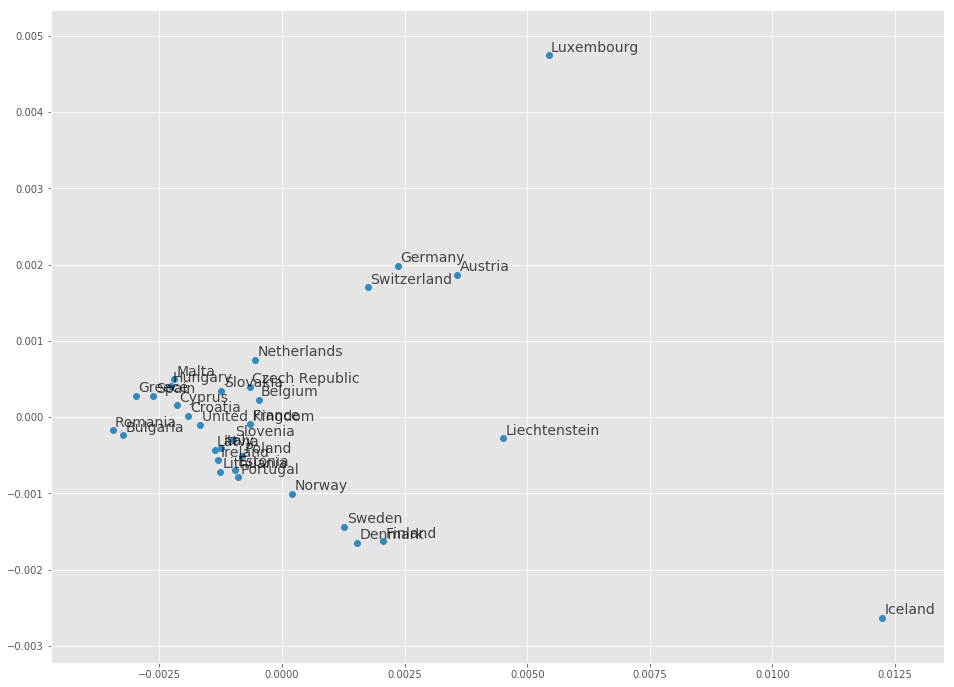

In [10]:
from sklearn.decomposition import PCA

X = df_amenity_normalized.values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(X_pca[:, 0], X_pca[:, 1], 'o', color='C1')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_pca[i, 0] + 0.00005, X_pca[i, 1] + 0.00005), fontsize=14, alpha=0.7)
    
ax.margins(0.08)

We can already see some possible relationships by proximity of the countries like some of the Scandinavian countries or some of the German-speaking countries. We can also see some countries that are seemingly unrelated like Iceland.

It is important to note that PCA relies on the assumption that there are linear correlations in the data set. This makes it difficult when the data is not linearly correlated (e.g. as a donut shape, spiral shape). This leads us to a different set of procedures, namely manifold learning.

## Manifold Learning

Manifold learning, also considered non-linear dimensionality reduction is an approach to reduce the dimensions of a data set which then can be used for example to visualize the data in two or three dimensions. This is done by searching for a low dimensional embedding within the high dimensional space. This can help with data compression, reverse or deal with the curse of dimensionality, de-noising, visualization and even for a reasonable distance metric within a high dimensional geometry.

## t-distributed Stochastic Neighbor Embedding

A popular approach from manifold learning is the t-distributed Stochasitc Neighbor Embedding (t-SNE) introduced by van der Maaten and Hinton in their paper [Visualizing Data using t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) from 2008. It is used for embedding high-dimensional data into a low-dimensional space such as two or three dimensions. It aims to iteratively reduce the distance between similar points and increase the distance between dissimilar points.

It is important to consider and test the hyperparameters when using t-SNE. One such hyperparameter is the perplexity which balances local and global relationships in the data, and is related to the number of nearest neighbors that are used. Typical values that can be explored are between 5 and 50. The other hyperparameters are the learning rate and the number of steps, which control the convergence of the algorithm.

To delve deeper into t-SNE, there is a wonderful article on [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/) by Wattenberg, et al. which gives an intuitive explanation of the use of t-SNE. It is also important to note that t-SNE has been shown to be unreliable for clustering, as it does not preserve distance. 

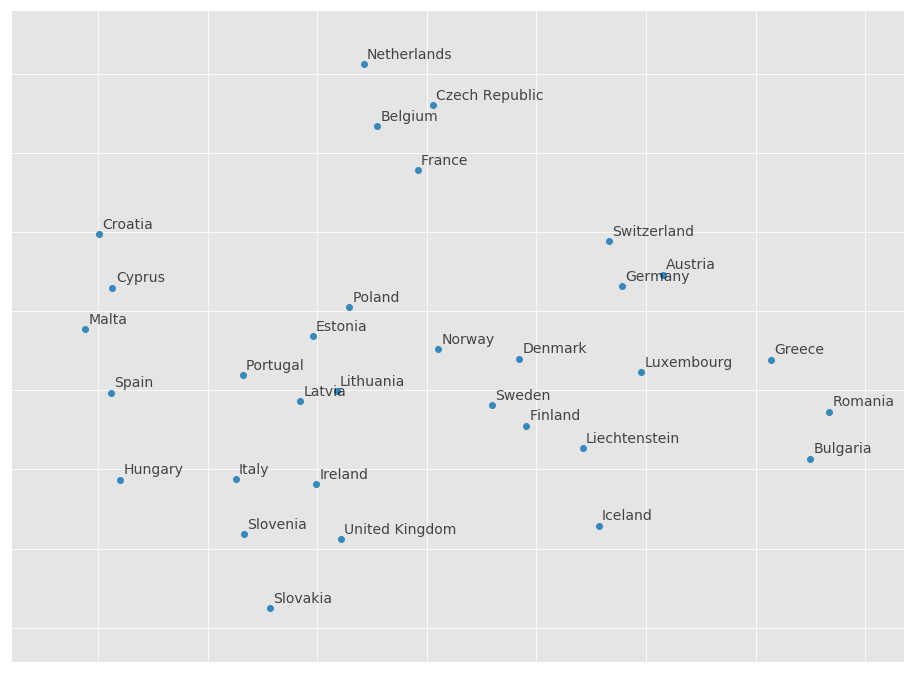

In [28]:
from sklearn.manifold import TSNE

X = df_amenity_normalized.values

tsne = TSNE(n_components=2, learning_rate=400, perplexity=5)
X_embedded = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(X_embedded[:, 0], X_embedded[:, 1], 'o', color='C1')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_embedded[i, 0] + 15, X_embedded[i, 1] + 15), fontsize=14, alpha=0.7)

ax.margins(0.1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

We can see again that Scandinavian countries like to be close to each other, as well as German-speaking countries. Another cluster of similar countries is formed by the Netherlands, Belgium, France and the Czech Republic. Poland, Estonia, Lithuania, Latvia and Portugal seem to be also similar in their distribution of amenities.

There are many other nonlinear dimensionality reduction techniques, many of which are covered by scikit-learn. They also have a great introduction for the various techniques in their [manifold learning](http://scikit-learn.org/stable/modules/manifold.html) section.

# Comparing Cities

After comparing countries, let's take a look if cities from two countries differ in their composition of amenities. For this we collected the number of amenities in the same way as before on the countries, but this time we counted the amenities within each city polygon. The two countries we aim to compare are Germany and France.

In [6]:
df = pd.read_csv('data/city_amenities_counts.csv')

df_pop = df['population']

mask = (df['country'] == 'Germany') | (df['country'] == 'France')
df_subset = df[mask]
df_pop_subset = df_pop[mask]

# Select subset with amenities
X = df_subset.loc[:, 'parking':'veterinary']
# Replace every 0 value with 0.1
X = X.applymap(lambda x: float(0.1 if x == 0 else x))
# Normalize values with population
X_normalized = X.apply(lambda row: row / df_pop_subset[row.name], axis=1)

y = df_subset['country'].map({'Germany':0, 'France':1})
X.head()

,parking,place_of_worship,school,bench,restaurant,fuel,cafe,fast_food,bank,waste_basket,...,waste_disposal,marketplace,bus_station,university,college,parking_entrance,swimming_pool,theatre,taxi,veterinary
12,7188.0,693.0,1163.0,8836.0,4062.0,328.0,2145.0,2098.0,443.0,2655.0,...,84.0,65.0,7.0,97.0,81.0,218.0,1.0,178.0,379.0,96.0
13,6380.0,426.0,626.0,3635.0,1839.0,235.0,810.0,860.0,357.0,584.0,...,67.0,40.0,13.0,86.0,12.0,319.0,0.1,79.0,146.0,69.0
14,3928.0,368.0,441.0,4906.0,1850.0,143.0,715.0,685.0,320.0,1660.0,...,31.0,33.0,4.0,95.0,19.0,737.0,29.0,59.0,189.0,59.0
15,2875.0,447.0,407.0,2024.0,1125.0,146.0,456.0,496.0,219.0,1107.0,...,14.0,23.0,3.0,85.0,23.0,235.0,0.1,48.0,103.0,27.0
16,1385.0,259.0,228.0,977.0,1128.0,79.0,348.0,332.0,167.0,263.0,...,28.0,10.0,3.0,65.0,6.0,141.0,0.1,36.0,56.0,11.0


Let's take a look again at the parallel coordinates plot to get a sense of the data.

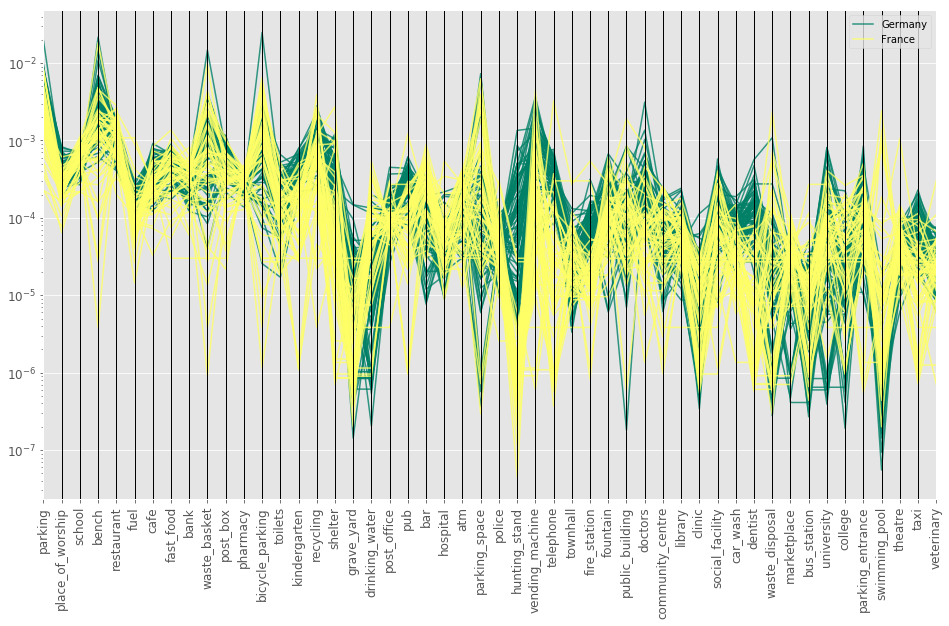

In [7]:
from pandas.plotting import parallel_coordinates

df_plot = pd.concat([X_normalized, df_subset['country']], axis=1)

plt.figure(figsize=(16, 9))
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
ax = parallel_coordinates(df_plot, 'country', colormap='summer', alpha=0.8)
ax.set_yscale('log')
plt.legend(fontsize=10);

We can already see differences between German and French cities for amenities like _hunting stand_, _vending machine_, _telephone_, _bench_ and a few others. Now we will apply again dimensionality reduction to our data set to see whether any relationships are visible.

## PCA Dimensionality Reduction

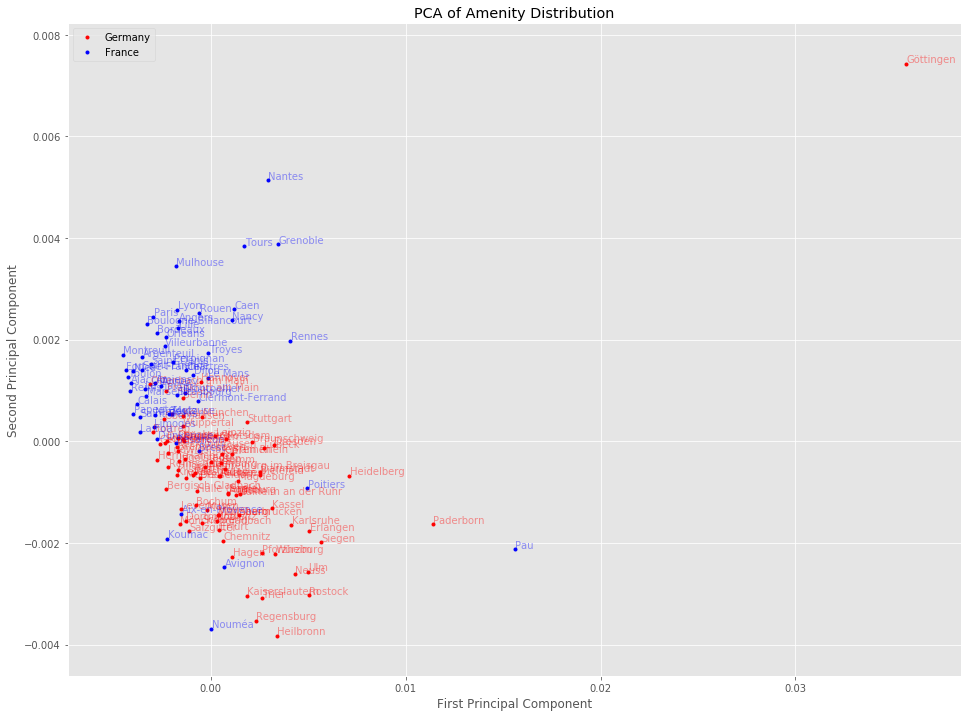

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized.values)

plt.figure(figsize=(16, 12))
plt.plot(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], 'r.', label='Germany')
plt.plot(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], 'b.', label='France')
plt.legend(fontsize=10, loc='upper left');
plt.title('PCA of Amenity Distribution')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

for i, country_idx in enumerate(df_subset.index):
    country = df.iloc[country_idx]['city']
    color = 'r' if y.iloc[i] == 0 else 'b'
    plt.annotate(country, (X_pca[i, 0] + 0.00002, X_pca[i, 1] + 0.00002), fontsize=10, alpha=0.4, color=color)
    
plt.margins(0.07)

Here we already can see that German and French cities seem to exhibit differences based on their amenity distribution.

## T-SNE Dimensionality Reduction

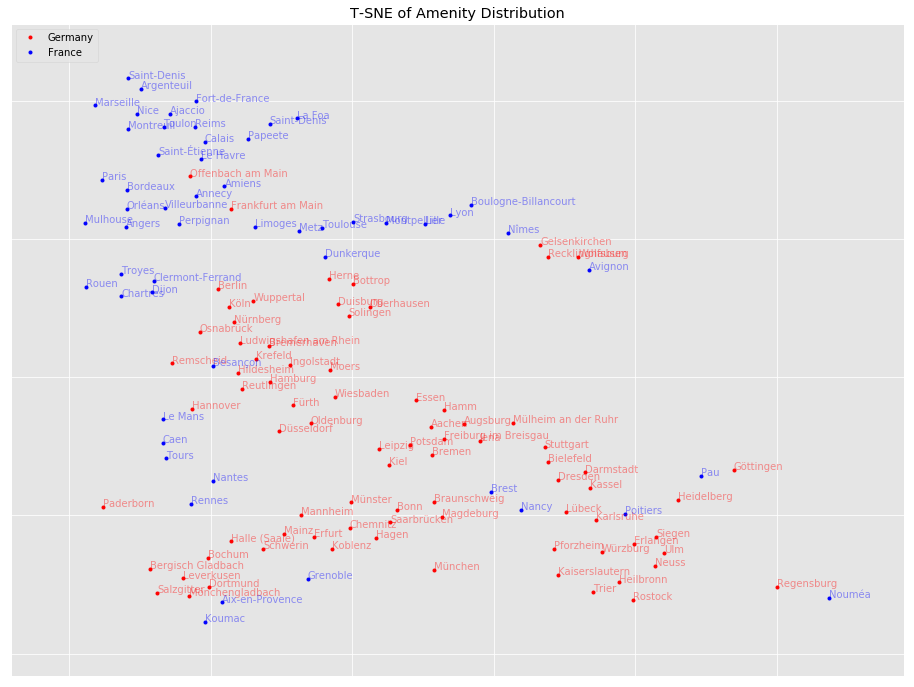

In [16]:
tsne = TSNE(n_components=2, learning_rate=1000, perplexity=10)
X_embedded = tsne.fit_transform(X_normalized.values)

plt.figure(figsize=(16, 12))
plt.plot(X_embedded[y == 0][:, 0], X_embedded[y == 0][:, 1], 'r.', label='Germany')
plt.plot(X_embedded[y == 1][:, 0], X_embedded[y == 1][:, 1], 'b.', label='France')
plt.title('T-SNE of Amenity Distribution')
plt.legend(fontsize=10, loc='upper left');

for i, country_idx in enumerate(df_subset.index):
    country = df.iloc[country_idx]['city']
    color = 'r' if y.iloc[i] == 0 else 'b'
    plt.annotate(country, (X_embedded[i, 0] + 0.00002, X_embedded[i, 1] + 0.00002), fontsize=10, alpha=0.4, color=color)

plt.margins(0.1)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

We can see that cities of the same country are close to each other, but not exclusively. This could mean that some cities share certain similiarities, while others are more distinctively German or French in their amenity distribution.

# Conclusion

We saw in this article how to compare countries and cities by using their amenities derived from OpenStreetMap. There are many paths to continue exploring. It might be worth exploring other algorithms from [manifold learning](http://scikit-learn.org/stable/modules/manifold.html). It might be interesting to extend this analysis to other countries (Keep in mind that OSM is not equally well annotated on the globe). By using the cities it might be possible to find some sort of centroid for a country which describes the country in the most distinctive way. Further, the amenity distributions might be used as feature vectors for classification of countries or cities.

All the code used for this and the previous article can be found in this [repository](https://github.com/njanakiev/osm-predict-economic-measurements). The previous article [How to Predict Economic Indicators with OpenStreetMap]({{ site.baseurl }}{% link _posts/2018-05-15-osm-predict-economic-indicators.md
 %}) covers more details on how the data was collected and other comparisons in the data. In the notebook on [graphical structure](https://github.com/njanakiev/osm-predict-economic-measurements/blob/master/graphical-structure-amenities.ipynb), the amenities are additionally compared by correlation and graphical structure by using the Graphical Lasso algorithm.